In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [69]:
motor_df = pd.read_csv("data/motor_window_features_10Hz_KNN_ready.csv")
secondary_df = pd.read_csv("data/secondary_window_features_10Hz_KNN_ready.csv")

print("Motor windows:", motor_df.shape)
print("Secondary windows:", secondary_df.shape)

secondary_df.head(5)

Motor windows: (535, 40)
Secondary windows: (327, 40)


,t_10hz_mean,timestamp_mean,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,...,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean,label
0,1199.5,119.95,113.150138,40.529548,-3.441663,635.907523,5.553246,5.245833,291.986450,2.299453,...,113.332708,90.740665,1.130833,1.962154,40.529483,-3.440870,1.623084,112.821897,1.346173,0
1,1459.5,145.95,114.150083,40.534167,-3.446960,646.916125,5.488333,5.245833,302.150958,2.292566,...,114.161667,86.033333,1.130833,1.834583,40.533707,-3.445721,1.942002,114.040458,1.481055,0
2,1719.5,171.95,113.640000,40.537531,-3.454224,656.628042,5.624167,5.245833,300.947750,2.273659,...,113.642333,85.158333,1.089167,1.843750,40.536876,-3.452646,2.135032,112.815292,1.486653,0
3,1979.5,197.95,113.905958,40.540639,-3.461621,668.014375,5.746667,5.245833,295.752417,2.211698,...,113.916542,84.652917,1.078333,1.850833,40.540000,-3.459575,2.760698,113.192542,0.810597,0
4,2239.5,223.95,114.565333,40.543104,-3.469355,680.536583,5.824167,5.245833,293.369667,2.384398,...,114.602958,84.732083,1.094167,1.874167,40.542584,-3.466453,3.569630,113.995958,0.816965,0


We isolate normal driving windows to use them as the reference baseline for distance calculations.

In [70]:
motor_normal_df = motor_df[motor_df["label"] == 2]
secondary_normal_df = secondary_df[secondary_df["label"] == 2]

print("Motor NORMAL:", motor_normal_df.shape)
print("Secondary NORMAL:", secondary_normal_df.shape)

Motor NORMAL: (170, 40)
Secondary NORMAL: (110, 40)


We define which numeric driving features are used to measure similarity and distance.

In [71]:
feature_cols = (motor_normal_df.select_dtypes(include=["int64", "float64"]).drop(columns=["label"]).columns.tolist())
print("Number of features:", len(feature_cols))
feature_cols[:5]

Number of features: 39


['t_10hz_mean', 'timestamp_mean', 'speed_kmh_mean', 'lat_mean', 'lon_mean']

Scaling = teaching the system what “normal” looks like, feature by feature.

In [72]:
motor_scaler = StandardScaler()
secondary_scaler = StandardScaler()

motor_normal_scaled = motor_scaler.fit_transform(motor_normal_df[feature_cols])
secondary_normal_scaled = secondary_scaler.fit_transform(secondary_normal_df[feature_cols])

print("Scalers fitted for both road types")

Scalers fitted for both road types


In [73]:
motor_knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
secondary_knn = NearestNeighbors(n_neighbors=5, metric="euclidean")

motor_knn.fit(motor_normal_scaled)
secondary_knn.fit(secondary_normal_scaled)

print("KNN models trained for motor & secondary")

KNN models trained for motor & secondary


In [74]:
def knn_distance(row, scaler, knn, feature_cols):
    row_df = row[feature_cols].to_frame().T
    row_scaled = scaler.transform(row_df)
    distances, _ = knn.kneighbors(row_scaled)
    return distances.mean()

Apply distance to all windows (per road)

In [75]:
motor_df["knn_distance"] = motor_df.apply(
    lambda row: knn_distance(row, motor_scaler, motor_knn, feature_cols),
    axis=1
)

In [76]:
secondary_df["knn_distance"] = secondary_df.apply(
    lambda row: knn_distance(row, secondary_scaler, secondary_knn, feature_cols),
    axis=1
)

In [77]:
print("Motor mean distance by label")
print(motor_df.groupby("label")["knn_distance"].mean())

print("\nSecondary mean distance by label")
print(secondary_df.groupby("label")["knn_distance"].mean())

Motor mean distance by label
label
0     9.497777
1    18.118607
2     1.553104
Name: knn_distance, dtype: float64

Secondary mean distance by label
label
0    11.034117
1    11.872582
2     2.107862
Name: knn_distance, dtype: float64


In [78]:
# Motor threshold (based on NORMAL only)
motor_normal_dist = motor_df[motor_df["label"] == 2]["knn_distance"]
motor_threshold = motor_normal_dist.mean() + 2 * motor_normal_dist.std()

# Secondary threshold
secondary_normal_dist = secondary_df[secondary_df["label"] == 2]["knn_distance"]
secondary_threshold = secondary_normal_dist.mean() + 2 * secondary_normal_dist.std()

motor_threshold, secondary_threshold

(np.float64(3.1310174974759786), np.float64(3.3189033502903285))

In [79]:
motor_abnormal = motor_df[motor_df["knn_distance"] > motor_threshold].copy()
secondary_abnormal = secondary_df[secondary_df["knn_distance"] > secondary_threshold].copy()

motor_abnormal.shape, secondary_abnormal.shape

((344, 41), (220, 41))

These are just quick checks to see if everything is okay

In [80]:
motor_abnormal["label"].value_counts()

label
1    208
0    127
2      9
Name: count, dtype: int64

In [81]:
motor_df.groupby("label")["knn_distance"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,154.0,9.497777,15.827434,1.586122,3.561238,4.957280,7.296057,96.049859
1,211.0,18.118607,30.679579,2.372704,5.765132,7.799655,10.381865,128.370839
2,170.0,1.553104,0.788957,0.750604,1.020095,1.231511,1.807330,5.177361


In [82]:
motor_df.shape, motor_abnormal.shape
len(motor_abnormal) / len(motor_df)

0.6429906542056075

Preparing data for clustering

In [83]:
motor_X = motor_scaler.transform(motor_abnormal[feature_cols])
secondary_X = secondary_scaler.transform(secondary_abnormal[feature_cols])

In [84]:
from sklearn.cluster import KMeans

motor_kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

motor_clusters = motor_kmeans.fit_predict(motor_X)

motor_abnormal["cluster"] = motor_clusters
motor_abnormal["cluster"].value_counts()

cluster
0    309
1     19
2     16
Name: count, dtype: int64

In [85]:
secondary_kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

secondary_clusters = secondary_kmeans.fit_predict(secondary_X)

secondary_abnormal["cluster"] = secondary_clusters
secondary_abnormal["cluster"].value_counts()

cluster
2    101
0     91
1     28
Name: count, dtype: int64

Naming the clusters, we decide this through seeing which features are the highest in each cluster (for each type of aggressive or drowsy behaving there is features that explain the type of this action, example: max_speed --> overspeeding and so on...

In [86]:
# Look at average feature values per cluster (motor)
motor_cluster_summary = (
    motor_abnormal
    .groupby("cluster")[feature_cols]
    .mean()
)

motor_cluster_summary

,t_10hz_mean,timestamp_mean,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,...,num_vehicles_mean,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,4943.781077,494.378108,98.078137,40.479547,-3.422619,591.817552,3.962128,7.234170,149.380020,1.666064,...,1.464029,98.926379,111.024513,1.016808,2.700698,40.274563,-3.406974,2.054703,98.820019,-1.151836
1,2581.213750,258.121375,89.173330,40.481543,-3.411545,592.336465,5.204803,15.444715,232.458606,1.225628,...,1.501601,91.594436,111.121798,1.042390,2.802544,40.481324,-3.412249,2.727827,91.572823,-3.403812
2,3815.537630,381.553763,96.778714,40.479824,-3.424510,594.022680,4.148385,20.598568,188.919003,1.786037,...,1.540990,100.289352,112.128229,1.025495,2.732708,40.478492,-3.426966,1.908712,100.658648,-0.167782


In [87]:
# Look at average feature values per cluster (secondary)
secondary_cluster_summary = (
    secondary_abnormal
    .groupby("cluster")[feature_cols]
    .mean()
)

secondary_cluster_summary

,t_10hz_mean,timestamp_mean,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,...,num_vehicles_mean,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,2844.301447,284.430145,93.170407,40.555438,-3.494769,659.168312,4.250068,8.945432,265.030969,2.493731,...,0.640842,94.234898,88.810014,1.145512,1.972784,40.553749,-3.492427,2.402207,93.841304,0.854620
1,3859.088571,385.908857,87.618605,40.560254,-3.506600,685.903168,3.609613,6.685565,248.214608,2.674874,...,0.796190,87.878984,79.728897,1.080089,1.674745,40.558994,-3.501485,17.869709,87.767247,-8.421191
2,3397.068020,339.706802,88.682899,40.547160,-3.476965,665.957520,3.911677,8.245440,129.114117,2.345008,...,0.289773,89.777634,89.881432,1.137209,2.050695,40.547153,-3.478473,2.102073,89.648656,0.892955


In [88]:
motor_cluster_summary["harsh_score"] = (
    motor_cluster_summary["vert_acc_mean"].rank() +
    motor_cluster_summary["horiz_acc_mean"].rank()
)

motor_cluster_summary["overspeed_score"] = (
    motor_cluster_summary["speed_kmh_mean"].rank() +
    motor_cluster_summary["speed_ratio_mean"].rank()
)

motor_cluster_summary["unstable_score"] = (
    motor_cluster_summary["difcourse_mean"].rank()
    + motor_cluster_summary["horiz_acc_mean"].rank()
    + motor_cluster_summary["course_mean"].rank()
)

motor_cluster_summary[
    ["harsh_score", "overspeed_score", "unstable_score"]
]

,harsh_score,overspeed_score,unstable_score
cluster,,,
0,2.0,5.0,4.0
1,5.0,2.0,6.0
2,5.0,5.0,8.0


In [89]:
motor_cluster_labels = {}

for cluster_id, row in motor_cluster_summary.iterrows():

    scores = {
        "Overspeeding": row["overspeed_score"],
        "Harsh acceleration / braking": row["harsh_score"],
        "Unstable driving": row["unstable_score"]
    }

    dominant_behavior = max(scores, key=scores.get)
    motor_cluster_labels[cluster_id] = dominant_behavior

    motor_cluster_labels = {
    0: "Overspeeding",
    1: "Harsh acceleration / braking",
    2: "Unstable driving"
}

motor_cluster_labels

{0: 'Overspeeding', 1: 'Harsh acceleration / braking', 2: 'Unstable driving'}

In [90]:
motor_cluster_summary[
    ["speed_kmh_mean", "vert_acc_mean", "horiz_acc_mean", "difcourse_mean",
     "overspeed_score", "harsh_score", "unstable_score"]
]

,speed_kmh_mean,vert_acc_mean,horiz_acc_mean,difcourse_mean,overspeed_score,harsh_score,unstable_score
cluster,,,,,,,
0,98.078137,3.962128,7.234170,1.666064,5.0,2.0,4.0
1,89.173330,5.204803,15.444715,1.225628,2.0,5.0,6.0
2,96.778714,4.148385,20.598568,1.786037,5.0,5.0,8.0


Now for secondary

In [91]:
secondary_cluster_summary["overspeed_score"] = (
    secondary_cluster_summary["speed_kmh_mean"].rank() +
    secondary_cluster_summary["speed_ratio_mean"].rank()
)

secondary_cluster_summary["harsh_score"] = (
    secondary_cluster_summary["vert_acc_mean"].rank() +
    secondary_cluster_summary["horiz_acc_mean"].rank()
)

secondary_cluster_summary["unstable_score"] = (
    secondary_cluster_summary["difcourse_mean"].rank()
    + secondary_cluster_summary["horiz_acc_mean"].rank()

)

secondary_cluster_summary[
    ["harsh_score", "overspeed_score", "unstable_score"]
]

,harsh_score,overspeed_score,unstable_score
cluster,,,
0,6.0,5.0,5.0
1,2.0,2.0,4.0
2,4.0,5.0,3.0


In [92]:
secondary_cluster_labels = {}

for cluster_id, row in secondary_cluster_summary.iterrows():

    scores = {
        "Overspeeding": row["overspeed_score"],
        "Harsh acceleration / braking": row["harsh_score"],
        "Unstable driving": row["unstable_score"]
    }

    dominant_behavior = max(scores, key=scores.get)
    secondary_cluster_labels[cluster_id] = dominant_behavior

secondary_cluster_labels

{0: 'Harsh acceleration / braking', 1: 'Unstable driving', 2: 'Overspeeding'}

In [93]:
secondary_cluster_summary[
    ["speed_kmh_mean", "vert_acc_mean", "horiz_acc_mean", "difcourse_mean",
     "overspeed_score", "harsh_score", "unstable_score"]
]

,speed_kmh_mean,vert_acc_mean,horiz_acc_mean,difcourse_mean,overspeed_score,harsh_score,unstable_score
cluster,,,,,,,
0,93.170407,4.250068,8.945432,2.493731,5.0,6.0,5.0
1,87.618605,3.609613,6.685565,2.674874,2.0,2.0,4.0
2,88.682899,3.911677,8.245440,2.345008,5.0,4.0,3.0


### KNN NORMAL DIFFERENCES (Tells us how far a window is from normal driving) & CLUSTERING (Tell us what type of abnormal behaviour it looks like) PHASE IS DONE

### Now we move to the next step: ALERTS APPEARING ON THE APP:
This is the logic:

If knn_distance > threshold → abnormal
Else → no alert


In [94]:
def motor_alert(row):

    if pd.isna(row["cluster_label"]):
        return "No alert"

    return row["cluster_label"]

In [95]:
def secondary_alert(row):

    if pd.isna(row["cluster_label"]):
        return "No alert"

    return row["cluster_label"]

Here we only assign clusters and behavior labels to windows that are far from normal, while normal windows remain unclustered and produce no alerts.

In [96]:
motor_df["cluster"] = np.nan
motor_df.loc[motor_abnormal.index, "cluster"] = motor_abnormal["cluster"]
motor_df["cluster_label"] = motor_df["cluster"].map(motor_cluster_labels)

In [97]:
secondary_df["cluster"] = np.nan
secondary_df.loc[secondary_abnormal.index, "cluster"] = secondary_abnormal["cluster"]
secondary_df["cluster_label"] = secondary_df["cluster"].map(secondary_cluster_labels)

In [98]:
motor_df["alert"] = motor_df.apply(
    motor_alert,
    axis=1
)
motor_df[["knn_distance", "cluster_label", "alert"]].head(10)

,knn_distance,cluster_label,alert
0,6.023721,Overspeeding,Overspeeding
1,5.465373,Overspeeding,Overspeeding
2,5.254406,Overspeeding,Overspeeding
3,4.722549,Overspeeding,Overspeeding
4,4.460244,Overspeeding,Overspeeding
5,4.666339,Overspeeding,Overspeeding
6,5.218133,Overspeeding,Overspeeding
7,5.385052,Overspeeding,Overspeeding
8,5.273426,Overspeeding,Overspeeding
9,5.254328,Overspeeding,Overspeeding


In [99]:
secondary_df["alert"] = secondary_df.apply(
    secondary_alert,
    axis=1
)

secondary_df[["knn_distance", "cluster_label", "alert"]].head(10)

,knn_distance,cluster_label,alert
0,10.350809,Harsh acceleration / braking,Harsh acceleration / braking
1,9.510120,Harsh acceleration / braking,Harsh acceleration / braking
2,9.050889,Harsh acceleration / braking,Harsh acceleration / braking
3,8.658917,Harsh acceleration / braking,Harsh acceleration / braking
4,8.565062,Harsh acceleration / braking,Harsh acceleration / braking
5,10.252315,Harsh acceleration / braking,Harsh acceleration / braking
6,10.931043,Harsh acceleration / braking,Harsh acceleration / braking
7,10.305757,Harsh acceleration / braking,Harsh acceleration / braking
8,10.399414,Harsh acceleration / braking,Harsh acceleration / braking
9,10.683659,Harsh acceleration / braking,Harsh acceleration / braking


In [100]:
motor_df["alert"].value_counts()

alert
Overspeeding                    309
No alert                        191
Harsh acceleration / braking     19
Unstable driving                 16
Name: count, dtype: int64

In [101]:
secondary_df["alert"].value_counts()

alert
No alert                        107
Overspeeding                    101
Harsh acceleration / braking     91
Unstable driving                 28
Name: count, dtype: int64

Now we create the mapping messages

In [102]:
alert_messages = {
    "Overspeeding": "⚠️ Speed limit exceeded",
    "Harsh acceleration / braking": "⚠️ Harsh driving detected",
    "Unstable driving": "⚠️ Vehicle instability detected",
    "No alert": "Normal driving"
}

In [103]:
motor_df["alert_message"] = motor_df["alert"].map(alert_messages)
secondary_df["alert_message"] = secondary_df["alert"].map(alert_messages)

In [104]:
motor_df[["alert", "alert_message"]].head()

,alert,alert_message
0,Overspeeding,⚠️ Speed limit exceeded
1,Overspeeding,⚠️ Speed limit exceeded
2,Overspeeding,⚠️ Speed limit exceeded
3,Overspeeding,⚠️ Speed limit exceeded
4,Overspeeding,⚠️ Speed limit exceeded


In [105]:
secondary_df[["alert", "alert_message"]].head()

,alert,alert_message
0,Harsh acceleration / braking,⚠️ Harsh driving detected
1,Harsh acceleration / braking,⚠️ Harsh driving detected
2,Harsh acceleration / braking,⚠️ Harsh driving detected
3,Harsh acceleration / braking,⚠️ Harsh driving detected
4,Harsh acceleration / braking,⚠️ Harsh driving detected


### Normalizing

In [106]:
motor_alert_pct = (
    motor_df["alert"]
    .value_counts(normalize=True) * 100
).round(2)

motor_alert_pct

alert
Overspeeding                    57.76
No alert                        35.70
Harsh acceleration / braking     3.55
Unstable driving                 2.99
Name: proportion, dtype: float64

In [107]:
secondary_alert_pct = (
    secondary_df["alert"]
    .value_counts(normalize=True) * 100
).round(2)

secondary_alert_pct

alert
No alert                        32.72
Overspeeding                    30.89
Harsh acceleration / braking    27.83
Unstable driving                 8.56
Name: proportion, dtype: float64

### Side-by-side comparison table

In [108]:
alert_comparison = (
    pd.concat(
        [
            motor_alert_pct.rename("Motorway (%)"),
            secondary_alert_pct.rename("Secondary (%)")
        ],
        axis=1
    )
    .fillna(0)
)

alert_comparison

,Motorway (%),Secondary (%)
alert,,
Overspeeding,57.76,30.89
No alert,35.70,32.72
Harsh acceleration / braking,3.55,27.83
Unstable driving,2.99,8.56


<Axes: title={'center': 'Alert Distribution by Road Type'}, xlabel='alert'>

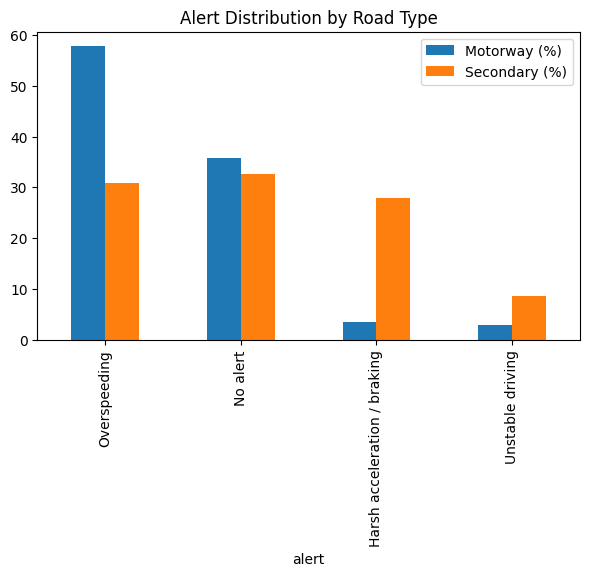

In [109]:
alert_comparison.plot(
    kind="bar",
    figsize=(7,4),
    title="Alert Distribution by Road Type"
)

The alert distribution aligns with real-world driving expectations, confirming that the KNN-based detection and clustering pipeline produces meaningful and context-aware driving risk alerts.

# NOW WE REACHED THE PERFORMANCE SCORING

### `“Given all detected behaviours, how risky is this driving profile?”`



We need a score that: increases when alerts increase, increases when alerts are severe and easy to explain

The clean formula we’ll use
Average severity × scaling factor

In [110]:
motor_df = motor_df.reset_index(drop=True)
motor_df["session_id"] = motor_df.index // 30

secondary_df = secondary_df.reset_index(drop=True)
secondary_df["session_id"] = secondary_df.index // 30

In [111]:
severity_map = {
    "No alert": 0,
    "Unstable driving": 1,
    "Harsh acceleration / braking": 2,
    "Overspeeding": 3
}

In [112]:
motor_df["severity"] = motor_df["alert"].map(severity_map)
secondary_df["severity"] = secondary_df["alert"].map(severity_map)

In [113]:
motor_avg_severity = motor_df["severity"].mean()
motor_avg_severity

np.float64(1.8336448598130841)

In [114]:
secondary_avg_severity = secondary_df["severity"].mean()
secondary_avg_severity

np.float64(1.5688073394495412)

In [115]:
motor_session_stats = (
    motor_df
    .groupby("session_id")
    .agg(
        avg_severity=("severity", "mean"),
        alert_count=("severity", lambda x: (x > 0).sum()),
        total_windows=("severity", "count")
    )
    .reset_index()
)

motor_session_stats["alert_ratio"] = (
    motor_session_stats["alert_count"] / motor_session_stats["total_windows"]
)

motor_session_stats.head()

,session_id,avg_severity,alert_count,total_windows,alert_ratio
0,0,3.0,30,30,1.000000
1,1,3.0,30,30,1.000000
2,2,0.7,7,30,0.233333
3,3,1.4,14,30,0.466667
4,4,2.7,27,30,0.900000


In [116]:
secondary_session_stats = (
    secondary_df
    .groupby("session_id")
    .agg(
        avg_severity=("severity", "mean"),
        alert_count=("severity", lambda x: (x > 0).sum()),
        total_windows=("severity", "count")
    )
    .reset_index()
)

secondary_session_stats["alert_ratio"] = (
    secondary_session_stats["alert_count"] / secondary_session_stats["total_windows"]
)

secondary_session_stats.head()

,session_id,avg_severity,alert_count,total_windows,alert_ratio
0,0,2.400000,30,30,1.000000
1,1,0.833333,10,30,0.333333
2,2,2.066667,30,30,1.000000
3,3,1.166667,12,30,0.400000
4,4,2.000000,28,30,0.933333


In [117]:
def fuzzy_low(x, a, b):
    if x <= a:
        return 1
    elif a < x < b:
        return (b - x) / (b - a)
    else:
        return 0

def fuzzy_high(x, a, b):
    if x >= b:
        return 1
    elif a < x < b:
        return (x - a) / (b - a)
    else:
        return 0

def fuzzy_medium(x, a, b, c):
    if a < x < b:
        return (x - a) / (b - a)
    elif b <= x < c:
        return (c - x) / (c - b)
    else:
        return 0

In [118]:
# Test fuzzy membership on first session
test_row = motor_session_stats.iloc[0]

sev = test_row["avg_severity"]
ratio = test_row["alert_ratio"]

print("Severity:", sev)
print("Alert Ratio:", ratio)

print("\nSeverity Membership:")
print("Low:", fuzzy_low(sev, 0.5, 1.5))
print("Medium:", fuzzy_medium(sev, 0.5, 1.5, 2.5))
print("High:", fuzzy_high(sev, 1.5, 2.5))

print("\nAlert Ratio Membership:")
print("Low:", fuzzy_low(ratio, 0.2, 0.5))
print("Medium:", fuzzy_medium(ratio, 0.2, 0.5, 0.8))
print("High:", fuzzy_high(ratio, 0.5, 0.8))

Severity: 3.0
Alert Ratio: 1.0

Severity Membership:
Low: 0
Medium: 0
High: 1

Alert Ratio Membership:
Low: 0
Medium: 0
High: 1


In [119]:
# Test fuzzy membership on first session
test_row = secondary_session_stats.iloc[0]

sev = test_row["avg_severity"]
ratio = test_row["alert_ratio"]

print("Severity:", sev)
print("Alert Ratio:", ratio)

print("\nSeverity Membership:")
print("Low:", fuzzy_low(sev, 0.5, 1.5))
print("Medium:", fuzzy_medium(sev, 0.5, 1.5, 2.5))
print("High:", fuzzy_high(sev, 1.5, 2.5))

print("\nAlert Ratio Membership:")
print("Low:", fuzzy_low(ratio, 0.2, 0.5))
print("Medium:", fuzzy_medium(ratio, 0.2, 0.5, 0.8))
print("High:", fuzzy_high(ratio, 0.5, 0.8))

Severity: 2.4
Alert Ratio: 1.0

Severity Membership:
Low: 0
Medium: 0.10000000000000009
High: 0.8999999999999999

Alert Ratio Membership:
Low: 0
Medium: 0
High: 1


In [120]:
def compute_fuzzy_score(sev, ratio):

    # Membership values
    sev_low = fuzzy_low(sev, 0.5, 1.5)
    sev_med = fuzzy_medium(sev, 0.5, 1.5, 2.5)
    sev_high = fuzzy_high(sev, 1.5, 2.5)

    ratio_low = fuzzy_low(ratio, 0.2, 0.5)
    ratio_med = fuzzy_medium(ratio, 0.2, 0.5, 0.8)
    ratio_high = fuzzy_high(ratio, 0.5, 0.8)

    # Rule strengths
    high_risk = min(sev_high, ratio_high)
    medium_risk = max(sev_med, ratio_med)
    low_risk = min(sev_low, ratio_low)

    # Defuzzification (weighted average)
    score = (
        low_risk * 90 +
        medium_risk * 60 +
        high_risk * 20
    )

    weight_sum = low_risk + medium_risk + high_risk

    if weight_sum == 0:
        return 80  # default safe
    else:
        return round(score / weight_sum, 2)

In [121]:
# Test fuzzy score on first session
test_row = motor_session_stats.iloc[0]

sev = test_row["avg_severity"]
ratio = test_row["alert_ratio"]

fuzzy_score = compute_fuzzy_score(sev, ratio)

print("Severity:", sev)
print("Alert Ratio:", ratio)
print("Fuzzy Performance Score:", fuzzy_score)

Severity: 3.0
Alert Ratio: 1.0
Fuzzy Performance Score: 20.0


In [122]:
# Test fuzzy score on first session
test_row = secondary_session_stats.iloc[0]

sev = test_row["avg_severity"]
ratio = test_row["alert_ratio"]

fuzzy_score = compute_fuzzy_score(sev, ratio)

print("Severity:", sev)
print("Alert Ratio:", ratio)
print("Fuzzy Performance Score:", fuzzy_score)

Severity: 2.4
Alert Ratio: 1.0
Fuzzy Performance Score: 24.0


In [123]:
motor_session_stats["fuzzy_performance_score"] = motor_session_stats.apply(
    lambda row: compute_fuzzy_score(
        row["avg_severity"],
        row["alert_ratio"]
    ),
    axis=1
)

motor_session_stats.head(10)

,session_id,avg_severity,alert_count,total_windows,alert_ratio,fuzzy_performance_score
0,0,3.000000,30,30,1.000000,20.00
1,1,3.000000,30,30,1.000000,20.00
2,2,0.700000,7,30,0.233333,84.00
3,3,1.400000,14,30,0.466667,63.00
4,4,2.700000,27,30,0.900000,20.00
5,5,1.700000,17,30,0.566667,52.00
6,6,0.266667,6,30,0.200000,90.00
7,7,2.466667,26,30,0.866667,21.33
8,8,3.000000,30,30,1.000000,20.00
9,9,1.100000,11,30,0.366667,72.00


In [124]:
secondary_session_stats["fuzzy_performance_score"] = secondary_session_stats.apply(
    lambda row: compute_fuzzy_score(
        row["avg_severity"],
        row["alert_ratio"]
    ),
    axis=1
)

secondary_session_stats.head(10)

,session_id,avg_severity,alert_count,total_windows,alert_ratio,fuzzy_performance_score
0,0,2.400000,30,30,1.000000,24.00
1,1,0.833333,10,30,0.333333,76.67
2,2,2.066667,30,30,1.000000,37.33
3,3,1.166667,12,30,0.400000,70.00
4,4,2.000000,28,30,0.933333,40.00
5,5,1.933333,20,30,0.666667,42.67
6,6,0.833333,18,30,0.600000,60.00
7,7,2.166667,30,30,1.000000,33.33
8,8,0.466667,7,30,0.233333,86.67
9,9,2.733333,30,30,1.000000,20.00


# Phase (3): Feedback

In [125]:
def build_session_metrics(df, road_type):
    
    session_rows = []
    
    for session_id, session_df in df.groupby("session_id"):
                # --- Label distribution ---
        label_pct = (
            session_df["label"]
            .value_counts(normalize=True)
            .mul(100)
            .round(2)
            .to_dict()
        )

        # Map numeric labels to names
        label_map = {0: "Aggressive", 1: "Drowsy", 2: "Normal"}

        label_pct_named = {
            label_map[k]: v for k, v in label_pct.items()
        }
        # Dominant behavior
        behavior = max(label_pct_named, key=label_pct_named.get)
                
        total_windows = len(session_df)
        
        # Raw alert counts
        alert_counts = session_df["alert"].value_counts().to_dict()
        overspeed_count = alert_counts.get("Overspeeding", 0)
        harsh_braking_count = alert_counts.get("Harsh acceleration / braking", 0)
        unstable_count = alert_counts.get("Unstable driving", 0)

        # Percentage distribution
        alert_pct = (
            session_df["alert"]
            .value_counts(normalize=True)
            .mul(100)
            .round(2)
            .to_dict()
        )
        
        avg_knn = float(session_df["knn_distance"].mean())
        max_knn = float(session_df["knn_distance"].max())
        
        alert_count = session_df["alert"].ne("No alert").sum()
        total_windows = len(session_df)

        alert_ratio = alert_count / total_windows

        avg_severity = session_df["severity"].mean()

        fuzzy_score = compute_fuzzy_score(avg_severity, alert_ratio)
        
        session_rows.append({
            "session_id": int(session_id),
            "road_type": road_type,
            "total_windows": total_windows,
            "performance_score": fuzzy_score,
            "average_knn_distance": avg_knn,
            "max_knn_distance": max_knn,
            "alert_counts": alert_counts,
            "alert_distribution_pct": alert_pct,
            "label_distribution_pct": label_pct_named,
            "behavior": behavior,
            "overspeed_count": overspeed_count,
            "harsh_braking_count": harsh_braking_count,
            "lane_drift_count": unstable_count
        })
    
    return pd.DataFrame(session_rows)

In [126]:
motor_sessions = build_session_metrics(motor_df, "Motorway")
secondary_sessions = build_session_metrics(secondary_df, "Secondary")

motor_sessions.head(18)

,session_id,road_type,total_windows,performance_score,average_knn_distance,max_knn_distance,alert_counts,alert_distribution_pct,label_distribution_pct,behavior,overspeed_count,harsh_braking_count,lane_drift_count
0,0,Motorway,30,20.00,5.365771,7.124296,{'Overspeeding': 30},{'Overspeeding': 100.0},"{'Aggressive': 90.0, 'Drowsy': 10.0}",Aggressive,30,0,0
1,1,Motorway,30,20.00,8.472966,10.852094,{'Overspeeding': 30},{'Overspeeding': 100.0},{'Drowsy': 100.0},Drowsy,30,0,0
2,2,Motorway,30,84.00,2.483847,9.689973,"{'No alert': 23, 'Overspeeding': 7}","{'No alert': 76.67, 'Overspeeding': 23.33}","{'Normal': 80.0, 'Drowsy': 20.0}",Normal,7,0,0
3,3,Motorway,30,63.00,4.164652,11.065223,"{'No alert': 16, 'Overspeeding': 14}","{'No alert': 53.33, 'Overspeeding': 46.67}","{'Aggressive': 73.33, 'Normal': 26.67}",Aggressive,14,0,0
4,4,Motorway,30,20.00,6.978740,9.263552,"{'Overspeeding': 27, 'No alert': 3}","{'Overspeeding': 90.0, 'No alert': 10.0}","{'Drowsy': 66.67, 'Aggressive': 33.33}",Drowsy,27,0,0
5,5,Motorway,30,52.00,4.659704,10.284413,"{'Overspeeding': 17, 'No alert': 13}","{'Overspeeding': 56.67, 'No alert': 43.33}","{'Drowsy': 66.67, 'Normal': 33.33}",Drowsy,17,0,0
6,6,Motorway,30,90.00,16.627291,96.049859,"{'No alert': 24, 'Unstable driving': 4, 'Harsh...","{'No alert': 80.0, 'Unstable driving': 13.33, ...","{'Normal': 80.0, 'Aggressive': 20.0}",Normal,0,2,4
7,7,Motorway,30,21.33,8.388986,44.121821,"{'Overspeeding': 24, 'No alert': 4, 'Unstable ...","{'Overspeeding': 80.0, 'No alert': 13.33, 'Uns...","{'Aggressive': 83.33, 'Drowsy': 16.67}",Aggressive,24,0,2
8,8,Motorway,30,20.00,5.531863,8.876587,{'Overspeeding': 30},{'Overspeeding': 100.0},{'Drowsy': 100.0},Drowsy,30,0,0
9,9,Motorway,30,72.00,3.081973,7.552153,"{'No alert': 19, 'Overspeeding': 11}","{'No alert': 63.33, 'Overspeeding': 36.67}","{'Normal': 76.67, 'Drowsy': 23.33}",Normal,11,0,0


In [127]:
secondary_sessions.head(11)

,session_id,road_type,total_windows,performance_score,average_knn_distance,max_knn_distance,alert_counts,alert_distribution_pct,label_distribution_pct,behavior,overspeed_count,harsh_braking_count,lane_drift_count
0,0,Secondary,30,24.00,10.926358,14.914418,"{'Harsh acceleration / braking': 18, 'Overspee...","{'Harsh acceleration / braking': 60.0, 'Oversp...","{'Aggressive': 56.67, 'Drowsy': 43.33}",Aggressive,12,18,0
1,1,Secondary,30,76.67,4.365776,13.762739,"{'No alert': 20, 'Overspeeding': 5, 'Harsh acc...","{'No alert': 66.67, 'Overspeeding': 16.67, 'Ha...","{'Normal': 66.67, 'Drowsy': 20.0, 'Aggressive'...",Normal,5,5,0
2,2,Secondary,30,37.33,11.385336,15.511549,"{'Harsh acceleration / braking': 12, 'Overspee...","{'Harsh acceleration / braking': 40.0, 'Oversp...","{'Aggressive': 53.33, 'Drowsy': 46.67}",Aggressive,10,12,8
3,3,Secondary,30,70.00,5.124977,12.772439,"{'No alert': 18, 'Overspeeding': 11, 'Harsh ac...","{'No alert': 60.0, 'Overspeeding': 36.67, 'Har...","{'Normal': 63.33, 'Drowsy': 36.67}",Normal,11,1,0
4,4,Secondary,30,40.00,6.161998,10.729985,"{'Harsh acceleration / braking': 24, 'Overspee...","{'Harsh acceleration / braking': 80.0, 'Oversp...","{'Aggressive': 73.33, 'Drowsy': 20.0, 'Normal'...",Aggressive,4,24,0
5,5,Secondary,30,42.67,7.087646,11.873247,"{'Overspeeding': 18, 'No alert': 10, 'Harsh ac...","{'Overspeeding': 60.0, 'No alert': 33.33, 'Har...","{'Drowsy': 66.67, 'Normal': 33.33}",Drowsy,18,2,0
6,6,Secondary,30,60.00,12.883132,37.240562,"{'No alert': 12, 'Unstable driving': 11, 'Hars...","{'No alert': 40.0, 'Unstable driving': 36.67, ...","{'Aggressive': 60.0, 'Normal': 40.0}",Aggressive,0,7,11
7,7,Secondary,30,33.33,12.569225,19.427346,"{'Overspeeding': 14, 'Unstable driving': 9, 'H...","{'Overspeeding': 46.67, 'Unstable driving': 30...","{'Drowsy': 86.67, 'Aggressive': 13.33}",Drowsy,14,7,9
8,8,Secondary,30,86.67,3.894158,17.943671,"{'No alert': 23, 'Harsh acceleration / braking...","{'No alert': 76.67, 'Harsh acceleration / brak...","{'Normal': 80.0, 'Aggressive': 20.0}",Normal,0,7,0
9,9,Secondary,30,20.00,13.603664,17.339582,"{'Overspeeding': 22, 'Harsh acceleration / bra...","{'Overspeeding': 73.33, 'Harsh acceleration / ...","{'Drowsy': 76.67, 'Aggressive': 23.33}",Drowsy,22,8,0


In [128]:
def build_llm_payload(row):
    return {
        "behavior": row["behavior"],
        "performance_score": float(row["performance_score"]),
        "overspeed_count": int(row["overspeed_count"]),
        "harsh_braking_count": int(row["harsh_braking_count"]),
        "lane_drift_count": int(row["lane_drift_count"]),
        "road_type": row["road_type"],
        "total_windows": int(row["total_windows"])
    }

In [129]:
#TEST
session_payload = build_llm_payload(motor_sessions.iloc[7])
session_payload

{'behavior': 'Aggressive',
 'performance_score': 21.33,
 'overspeed_count': 24,
 'harsh_braking_count': 0,
 'lane_drift_count': 2,
 'road_type': 'Motorway',
 'total_windows': 30}

---------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------

In [130]:
motor_df.columns

Index(['t_10hz_mean', 'timestamp_mean', 'speed_kmh_mean', 'lat_mean',
       'lon_mean', 'alt_mean', 'vert_acc_mean', 'horiz_acc_mean',
       'course_mean', 'difcourse_mean', 'hdop_mean', 'vdop_mean', 'pdop_mean',
       'active_mean', 'acc_x_mean', 'acc_y_mean', 'acc_z_mean',
       'acc_x_kf_mean', 'acc_y_kf_mean', 'acc_z_kf_mean', 'roll_mean',
       'pitch_mean', 'yaw_mean', 'x_lane_mean', 'phi_mean', 'road_width_mean',
       'lane_state_mean', 'dist_front_mean', 'ttc_front_mean',
       'num_vehicles_mean', 'gps_speed_mean', 'max_speed_mean',
       'speed_rel_mean', 'num_lanes_mean', 'lat_osm_mean', 'lon_osm_mean',
       'osm_delay_mean', 'gps_speed_osm_mean', 'speed_ratio_mean', 'label',
       'knn_distance', 'cluster', 'cluster_label', 'alert', 'alert_message',
       'session_id', 'severity'],
      dtype='str')

In [131]:
secondary_df.columns

Index(['t_10hz_mean', 'timestamp_mean', 'speed_kmh_mean', 'lat_mean',
       'lon_mean', 'alt_mean', 'vert_acc_mean', 'horiz_acc_mean',
       'course_mean', 'difcourse_mean', 'hdop_mean', 'vdop_mean', 'pdop_mean',
       'active_mean', 'acc_x_mean', 'acc_y_mean', 'acc_z_mean',
       'acc_x_kf_mean', 'acc_y_kf_mean', 'acc_z_kf_mean', 'roll_mean',
       'pitch_mean', 'yaw_mean', 'x_lane_mean', 'phi_mean', 'road_width_mean',
       'lane_state_mean', 'dist_front_mean', 'ttc_front_mean',
       'num_vehicles_mean', 'gps_speed_mean', 'max_speed_mean',
       'speed_rel_mean', 'num_lanes_mean', 'lat_osm_mean', 'lon_osm_mean',
       'osm_delay_mean', 'gps_speed_osm_mean', 'speed_ratio_mean', 'label',
       'knn_distance', 'cluster', 'cluster_label', 'alert', 'alert_message',
       'session_id', 'severity'],
      dtype='str')

In [132]:
len(motor_df)

535

In [133]:
len(secondary_df)

327

-----------------------------------------------------------------------------------------------------------------------------------------------

In [134]:
motor_pred_df = pd.read_csv("C:\\Users\\lorna\\OneDrive\\Desktop\\DriveIQ\\ml-model\\notebooks\\data\\motor_predictions_all_windows.csv")
secondary_pred_df = pd.read_csv("C:\\Users\\lorna\\OneDrive\\Desktop\\DriveIQ\\ml-model\\notebooks\\data\\secondary_predictions_all_windows.csv")

In [135]:
motor_df["predicted_label_encoded"] = motor_pred_df["predicted_label_encoded"]
secondary_df["predicted_label_encoded"] = secondary_pred_df["predicted_label_encoded"]

In [136]:
motor_df[["label", "predicted_label_encoded"]].head(300)

,label,predicted_label_encoded
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
295,2,2
296,2,2
297,2,2
298,2,2


In [137]:
secondary_df[["label", "predicted_label_encoded"]].head(700)

,label,predicted_label_encoded
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
322,2,2
323,2,2
324,2,2
325,2,2


In [138]:
motor_df["predicted_label_encoded"].value_counts()

predicted_label_encoded
1    191
0    178
2    166
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

FINAL JSON

In [139]:
motor_df["label"] = motor_df["predicted_label_encoded"]
secondary_df["label"] = secondary_df["predicted_label_encoded"]

In [140]:
motor_df["window_id"] = motor_df.groupby("session_id").cumcount()
secondary_df["window_id"] = secondary_df.groupby("session_id").cumcount()

In [141]:
SPEED_LIMITS = {
    "Motorway": 120,
    "Secondary": 90
}

In [142]:
FEATURE_METADATA = {
    "Overspeeding": [
        {"column": "max_speed_mean", "name": "Maximum Speed", "unit": "km/h"},
        {"column": "speed_ratio_mean", "name": "Speed Ratio", "unit": "ratio"}
    ],
    "Harsh acceleration / braking": [
        {"column": "vert_acc_mean", "name": "Vertical Acceleration", "unit": "m/s²"},
        {"column": "horiz_acc_mean", "name": "Horizontal Acceleration", "unit": "m/s²"}
    ],
    "Unstable driving": [
        {"column": "difcourse_mean", "name": "Course Deviation", "unit": "degrees"},
        {"column": "horiz_acc_mean", "name": "Horizontal Acceleration", "unit": "m/s²"},
        {"column": "course_mean", "name": "Average Steering Course", "unit": "degrees"}
    ]
}

In [ ]:
def build_sessions_with_windows(df, road_type):

    sessions_output = []

    label_map = {0: "Aggressive", 1: "Drowsy", 2: "Normal"}

    for session_id, session_df in df.groupby("session_id"):

        windows_list = []

        for _, row in session_df.iterrows():

            alert_type = row["alert"]

            trigger_features = []

            if alert_type in FEATURE_METADATA:
                for feature_info in FEATURE_METADATA[alert_type]:

                    column = feature_info["column"]

                    if column in row:
                        trigger_features.append({
                            "feature": feature_info["name"],
                            "value": float(row[column]),
                            "unit": feature_info["unit"]
                        })

            window_dict = {
                "window_id": int(row["window_id"]),
                "predicted_label": label_map[row["label"]],
                "alert_cause": row["alert"],
                "severity": float(row["severity"]),
                "knn_distance": float(row["knn_distance"]),
                "trigger_features": trigger_features
            }

            windows_list.append(window_dict)

        avg_severity = session_df["severity"].mean()
        alert_ratio = session_df["alert"].ne("No alert").sum() / len(session_df)
        performance_score = compute_fuzzy_score(avg_severity, alert_ratio)

        session_dict = {
            "session_id": int(session_id),
            "road_type": road_type,
            "performance_score": float(performance_score),
            "windows": windows_list
        }

        sessions_output.append(session_dict)

    return sessions_output

In [144]:
motor_json = build_sessions_with_windows(motor_df, "Motorway")
secondary_json = build_sessions_with_windows(secondary_df, "Secondary")

final_json = motor_json + secondary_json

In [145]:
motor_json[0]

{'session_id': 0,
 'road_type': 'Motorway',
 'performance_score': 20.0,
 'windows': [{'window_id': 0,
   'predicted_label': 'Aggressive',
   'alert_cause': 'Overspeeding',
   'severity': 3.0,
   'knn_distance': 6.023720742197218,
   'trigger_features': [{'feature': 'Maximum Speed',
     'value': 119.26994733508651,
     'unit': 'km/h'},
    {'feature': 'Speed Ratio', 'value': 1.0554892424469968, 'unit': 'ratio'}]},
  {'window_id': 1,
   'predicted_label': 'Aggressive',
   'alert_cause': 'Overspeeding',
   'severity': 3.0,
   'knn_distance': 5.465372540901672,
   'trigger_features': [{'feature': 'Maximum Speed',
     'value': 120.0,
     'unit': 'km/h'},
    {'feature': 'Speed Ratio', 'value': 1.1041597222222224, 'unit': 'ratio'}]},
  {'window_id': 2,
   'predicted_label': 'Aggressive',
   'alert_cause': 'Overspeeding',
   'severity': 3.0,
   'knn_distance': 5.254406268403559,
   'trigger_features': [{'feature': 'Maximum Speed',
     'value': 120.0,
     'unit': 'km/h'},
    {'feature':

In [146]:
secondary_json[0]

{'session_id': 0,
 'road_type': 'Secondary',
 'performance_score': 24.0,
 'windows': [{'window_id': 0,
   'predicted_label': 'Aggressive',
   'alert_cause': 'Harsh acceleration / braking',
   'severity': 2.0,
   'knn_distance': 10.350809164700545,
   'trigger_features': [{'feature': 'Vertical Acceleration',
     'value': 5.553245686365935,
     'unit': 'm/s²'},
    {'feature': 'Horizontal Acceleration',
     'value': 5.245833333333334,
     'unit': 'm/s²'}]},
  {'window_id': 1,
   'predicted_label': 'Aggressive',
   'alert_cause': 'Harsh acceleration / braking',
   'severity': 2.0,
   'knn_distance': 9.510120495054002,
   'trigger_features': [{'feature': 'Vertical Acceleration',
     'value': 5.488333333333333,
     'unit': 'm/s²'},
    {'feature': 'Horizontal Acceleration',
     'value': 5.245833333333334,
     'unit': 'm/s²'}]},
  {'window_id': 2,
   'predicted_label': 'Aggressive',
   'alert_cause': 'Harsh acceleration / braking',
   'severity': 2.0,
   'knn_distance': 9.05088878366

In [147]:
import json

with open("motor_output.json", "w") as f:
    json.dump(motor_json, f, indent=4)

print("Motor JSON saved successfully.")

Motor JSON saved successfully.


In [148]:
with open("secondary_output.json", "w") as f:
    json.dump(secondary_json, f, indent=4)

print("Secondary JSON saved successfully.")

Secondary JSON saved successfully.


In [149]:
import joblib
joblib.dump(motor_scaler, "../models/motor_knn_scaler.pkl")
joblib.dump(secondary_scaler, "../models/secondary_knn_scaler.pkl")

['../models/secondary_knn_scaler.pkl']

In [150]:
joblib.dump(motor_knn, "../models/motor_knn_model.pkl")
joblib.dump(secondary_knn, "../models/secondary_knn_model.pkl")

['../models/secondary_knn_model.pkl']

In [151]:
import json
with open("../models/knn_feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

In [152]:
thresholds = {
    "motor": float(motor_threshold),
    "secondary": float(secondary_threshold)
}

with open("../models/knn_thresholds.json", "w") as f:
    json.dump(thresholds, f)